# Data Preprocessing

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objs as go
import seaborn as sns

from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer

import cv2
import csv
from bs4 import BeautifulSoup

import lazypredict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from skimage.feature import local_binary_pattern

from category_encoders import TargetEncoder,  CountEncoder

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]

In [2]:
# Download nltk packages if not already downloaded
# nltk.download()

## Load the dataset

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df_origin = pd.read_csv('games-classification-dataset.csv', 
                        parse_dates=['Original Release Date' , 'Current Version Release Date'], 
                        date_parser=dateparse)

## Target Variable Encoding

In [4]:
def rate_preprocess(_df):
  # Define mapping dictionary
  mapping = {
    'Low': 0, 
    'Intermediate': 1,
    'High': 2}

  # Apply mapping to column
  _df['Rate'] = _df['Rate'].apply(lambda x: mapping[x])
  
  return _df

df_origin = rate_preprocess(df_origin)

## Data Gathering

### Download the icons

In [5]:
# Convert to string
df_origin['Icon URL'] = df_origin['Icon URL'].astype(str)

# Download the images
def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


# Create a folder to store the images
if not os.path.exists('icons'):
    os.makedirs('icons')

# Download the images if they don't exist
for i, row in tqdm(df_origin.iterrows(), total=df_origin.shape[0]):
    if not os.path.exists('icons/' + str(i) + '.png'):
        download_image(row['Icon URL'], 'icons/' + str(i) + '.png')
        
# Replace the URL with the icon filename which is the index of the row
df_origin['Icon URL'] = df_origin.apply(lambda row : f'icons/{row.name}.png', axis=1)

100%|██████████| 5214/5214 [00:00<00:00, 7415.99it/s]


### Download the reviews

In [6]:
def web_scrapping():
    data = pd.DataFrame(columns = ["ID","Reviews"])
    # Read CSV file
    # with open('games-regression-dataset.csv', newline='') as csvfile:
    with open('games-regression-dataset.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            url = row[0]  # URL is in first column
            filename = 'Reviews/'+os.path.basename(url)  # Extract filename from URL
            url +=  "?see-all=reviews"
            response = requests.get(url)
            if response.status_code == 200:  # Check if request was successful
                soup = BeautifulSoup(response.text, 'html.parser')
                blocks = soup.findAll("blockquote")
                review_list = []
                for blockquote in blocks:
                    review = blockquote.find('p').text
                    review_list.append(review)
                if len(review_list)!=0:
                    filename = re.sub(r'[^\d]+', '', filename)
                    new_row = {'ID': filename,"Reviews": review_list}
                    data = data._append(new_row, ignore_index=True)
                    
    data.to_csv('Reviews.csv', index=False)

In [7]:
def reviews_splitting(data):

    for i in range (len(data)):
        data.at[i, 'Reviews'] = data.at[i, "Reviews"].split("',")
        data.at[i,"ID"] =data.at[i,"ID"]
        
    data = data.explode('Reviews')
    return data

In [8]:
def reviews_cleaning(data):
  # Convert text to lowercase
  data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())

  # Replace newline characters with an empty string
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\n', ' ', x))

  # Remove black squares
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\u25a0', '', x))

  # Remove special characters and punctuations
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

  # Remove numbers
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.split() if not any(char.isdigit() for char in word)]))

  # Remove extra whitespaces
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\s+', ' ', x))

  # Remove stop words
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]))

  # Remove empty strings
  data = data[data['Reviews'].apply(lambda x: len(x)>0)]
  
  # Group by ID
  data = data.groupby('ID')['Reviews'].apply(list).reset_index()
  
  return data

In [9]:
# Web scrapping to get the html of the reviews, Only run once
# web_scrapping()

df_reviews = pd.read_csv('Reviews.csv')

df_reviews = reviews_splitting(df_reviews)

df_reviews = reviews_cleaning(df_reviews)

## Merge The Sentiment with the original dataset
df_origin = df_origin.merge(df_reviews, on='ID', how='left')

In [10]:
df_origin.shape

(5214, 19)

## Data Exploration

### General information

In [11]:
# df.head()

In [12]:
# df.info()

In [13]:
# df.isnull().sum()

### Genres

In [14]:
def genres_analysis(_df):
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    genre_counts = _df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
    print(genre_counts)


### Developer

In [15]:
def dev_analysis(_df):

    print(_df['Developer'].value_counts())
    
    # print the number developers with more than 1 game
    print(len(_df['Developer'].value_counts()[_df['Developer'].value_counts() > 1]))

    print(_df['Developer'].unique().size)

### Dates

In [16]:
def date_analysis(_df):
    # Plot the distribution of the date columns

    fig, ax = plt.subplots(5, 2, figsize=(20, 20))

    # df = date_preprocessing(df)

    # game_age distribution
    sns.histplot(_df['game_age'], ax=ax[0, 0])
    sns.boxplot(_df['game_age'], ax=ax[0, 1], orient='h')

    # last_update distribution
    sns.histplot(_df['last_update'], ax=ax[1, 0])
    sns.boxplot(_df['last_update'], ax=ax[1, 1], orient='h')

    # Original Release Date distribution
    sns.histplot(_df['Original Release Date'], ax=ax[2, 0])
    sns.boxplot(_df['Original Release Date'], ax=ax[2, 1], orient='h')

    # Current Version Release Date distribution
    sns.histplot(_df['Current Version Release Date'], ax=ax[3, 0])
    sns.boxplot(_df['Current Version Release Date'], ax=ax[3, 1], orient='h')

    # maintaning_period distribution
    sns.histplot(_df['maintaning_period'], ax=ax[4, 0])
    sns.boxplot(_df['maintaning_period'], ax=ax[4, 1], orient='h')

    plt.show()

# Date outliers are legitimate data points that are worth keeping, they are not errors nor anomalies

### Languages

In [17]:
def lang_analysis(_df):
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    langs_counts = _df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
    print(langs_counts[1:30])


In [18]:
# df.hist(figsize=(15, 15))

### General Analysis

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_column(dataframe, column_name, target_column=None):
    # Check if the column exists in the dataframe
    if column_name not in dataframe.columns:
        return "Column does not exist in the dataframe"
    
    # Check if the target column exists in the dataframe
    if target_column is not None and target_column not in dataframe.columns:
        return "Target column does not exist in the dataframe"
    
    column_data = dataframe[column_name]
    
    # Handle missing values
    if column_data.isnull().sum() > 0:
        # If there are missing values, drop them or impute them based on the nature of your problem
        column_data = column_data.dropna()
    
    # Check the datatype of the column
    column_dtype = column_data.dtype
    
    if column_dtype == 'object':
        # For categorical data
        
        # Calculate the frequency distribution
        freq_table = pd.crosstab(index=column_data, columns='count')
        
        # Plot the frequency distribution
        plt.figure(figsize=(10,5))
        sns.countplot(x=column_name, data=dataframe)
        plt.title(f"{column_name} Frequency Distribution")
        plt.xlabel(column_name)
        plt.ylabel("Frequency")
        plt.show()
        
        if target_column is not None:
            # Calculate the mean target value for each category
            target_mean = dataframe.groupby(column_name)[target_column].mean()
            
            # Plot the mean target value for each category
            plt.figure(figsize=(10,5))
            sns.barplot(x=target_mean.index, y=target_mean.values)
            plt.title(f"Mean {target_column} for each {column_name}")
            plt.xlabel(column_name)
            plt.ylabel(f"Mean {target_column}")
            plt.show()
        
    elif np.issubdtype(column_dtype, np.number):
        # For numerical data
        
        # Check for outliers using box plot
        plt.figure(figsize=(10,5))
        sns.boxplot(x=column_data)
        plt.title(f"{column_name} Boxplot")
        plt.xlabel(column_name)
        plt.show()
        
        # Calculate the summary statistics
        summary_statistics = column_data.describe()
        print(summary_statistics)
        
        if target_column is not None:
            # Plot the scatter plot between the column and the target variable
            plt.figure(figsize=(10,5))
            sns.scatterplot(x=column_data, y=dataframe[target_column])
            plt.title(f"{column_name} vs {target_column}")
            plt.xlabel(column_name)
            plt.ylabel(target_column)
            plt.show()
            
    else:
        return "Data type not recognized for the column"


## Dates preprocessing

In [20]:
def date_preprocess(_df, test=False):
    # Convert the datetime to ordinal
    _df['Original Release Date'] = _df['Original Release Date'].apply(lambda x: x.toordinal())
    _df['Current Version Release Date'] = _df['Current Version Release Date'].apply(lambda x: x.toordinal())
    
    # Impute missing values using simple imputer with median strategy
    if test:
        simple_imputer = pickle.load(open('imputers/date_simple.pkl', 'rb'))
    else:
        simple_imputer = SimpleImputer(strategy='median').fit(_df[['Original Release Date', 'Current Version Release Date']])
        pickle.dump(simple_imputer, open('imputers/date_simple.pkl', 'wb'))
    
    _df[['Original Release Date', 'Current Version Release Date']] = simple_imputer.transform(_df[['Original Release Date', 'Current Version Release Date']])
    
    # Create a new column with the age of the game
    _df['game_age'] = datetime.now().toordinal() - _df['Original Release Date']

    # Create a new column with the time since the last update
    _df['last_update'] = datetime.now().toordinal() - _df['Current Version Release Date']
    
    # Create a new column with the maintaning period
    _df['maintaning_period'] = _df['game_age'] - _df['last_update']

    return _df

## Developer preprocessing

### Target encoding approach

In [21]:
def dev_preprocess_target_enc(_df, test=False):
    """Preprocesses and encodes the 'Developer' column using target encoding.

    Args:
        df (DataFrame): DataFrame (either train or test, depending on the value of test)
        test (bool, optional): Boolean flag indicating whether the data is for testing (True) or training (False). Defaults to False.

    Returns:
        DataFrame: the preprocessed DataFrame with the new 'dev_avg' column
    """

    # Convert Developer column to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')  
      
    # Replace Developers with less than 2 games with 'Other'
    if not test:
        dev_counts = _df['Developer'].value_counts()
        other = dev_counts[dev_counts < 2].index
        _df['Developer'] = _df['Developer'].replace(other, np.nan)

    # Perform target encoding on Developer column
    if test:
        te = pickle.load(open('encoders/dev_te.pkl', 'rb'))
    else:
        te = TargetEncoder(cols=['Developer'], smoothing=20, handle_missing='return_nan').fit(_df[['Developer']], _df['Rate'])
        pickle.dump(te, open('encoders/dev_te.pkl', 'wb'))

    _df['dev_avg'] = te.transform(_df[['Developer']])
    
    # Impute missing values using KNN
    if test:
        knn = pickle.load(open('imputers/dev_knn.pkl', 'rb'))
    else:
        knn = KNNImputer(n_neighbors=5).fit(_df[['dev_avg']])
        pickle.dump(knn, open('imputers/dev_knn.pkl', 'wb'))
    
    _df['dev_avg'] = knn.transform(_df[['dev_avg']])
    _df['dev_avg'] = _df['dev_avg'].astype(float)
    
    return _df


### Frequency encoding approach

In [22]:
def dev_preprocess_freq_enc(_df, test):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')
    
    if not test:
        ce = CountEncoder(cols=['Developer']).fit(_df[['Developer']])
        pickle.dump(ce, open('encoders/dev_ce.pkl', 'wb'))
    else:
        ce = pickle.load(open('encoders/dev_ce.pkl', 'rb'))
    
    _df['dev_freq'] = ce.transform(_df[['Developer']])['Developer']
        
    return _df


## Genres preprocessing

### 1. NLP approach (Bag of Words)

In [23]:
def genres_preprocess_bow(_df, test=False):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

    # Join the list of genres into a single string
    genres = _df['Genres'].apply(lambda x: ' '.join(x))

    # Create a count Vectorizer and fit it to the genres
    count_vec = CountVectorizer()
    bow_genres = count_vec.fit_transform(genres)
    
    # Save the count vectorizer to be used on the test set
    pickle.dump(count_vec, open('encoders/count_vec_genre.pkl', 'wb'))

    # Apply principal component analysis to reduce the dimensionality
    pca = PCA(n_components=10)
    pca_genres = pca.fit_transform(bow_genres.toarray())
    
    # Save the pca to be used on the test set
    pickle.dump(pca, open('encoders/genre_pca.pkl', 'wb'))

    # Add the PCA-transformed genres to the original dataframe
    for i in range(10):
        _df[f'genreN_{i}'] = pca_genres[:, i]

    return _df

### 2. Dummy variables approach

In [24]:
def genres_preprocess_dummies(_df, test=False):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])
    
    if not test:
        
        # Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
        threshold = _df.shape[0] * 0.02
        
        other = _df['Genres'].explode().value_counts()[_df['Genres'].explode().value_counts() < threshold].index
        _df['Genres'] = _df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])
        
        # Get dummy variables for the genres
        genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
        
        # Save the genres dummies to be used on the test set
        genres.to_csv('encoders/genres.csv', index=False)
    
    else:
        # Load saved genres dummy variables
        saved_dummies = pd.read_csv('encoders/genres.csv')

        # Get the genres that are not in the saved dummy variables
        other = [genre for genre in _df['Genres'].explode().unique() if genre not in saved_dummies.columns]

        # Replace the genres that are not in the saved dummy variables with 'infrequent'
        _df['Genres'] = _df['Genres'].apply(lambda x: ['infrequent' if genre in other else genre for genre in x])

        # Preprocess test data using the saved dummy variables
        genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
        genres = genres.reindex(columns=saved_dummies.columns, fill_value=0)
        
        # Fill the dummy columns with 0 if nan
        genres = genres.fillna(0)

    
    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, genres], axis=1)
    
    # Fill the NaN values with 0
    genre_cols = [col for col in _df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
    _df[genre_cols] = _df[genre_cols].fillna(0) # fill the NaN values with 0
    
    return _df


## Languages preprocessing

### 1. NLP approach

In [25]:
def lang_preprocessing_bow(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    # Join the list of langs into a single string
    languages = _df['Languages'].apply(lambda x: ' '.join(x))
    
    # Create a count Vectorizer and fit it to the langs
    count_vec = CountVectorizer()
    bow_languages = count_vec.fit_transform(languages)
    
    # Save the count vectorizer to be used on the test set
    pickle.dump(count_vec, open('encoders/count_vec_lang.pkl', 'wb'))
    
    # Apply principal component analysis to reduce the dimensionality
    pca = PCA(n_components=10)
    pca_languages = pca.fit_transform(bow_languages.toarray())
    
    # Save the pca to be used on the test set
    pickle.dump(pca, open('encoders/pca_lang.pkl', 'wb'))
    
    # Add the PCA-transformed langs to the original dataframe
    for i in range(len(pca_languages[0])):
        _df[f'lang_{i}'] = pca_languages[:, i]
        
    return _df


### 2. Dummy variables approach

In [26]:
def langs_preprocess_dummies(_df, test = False):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x)) 
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    if not test:
        # Replace languages with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 10%)
        threshold = _df.shape[0] * 0.1
        
        # Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
        other = _df['Languages'].explode().value_counts()[_df['Languages'].explode().value_counts() < threshold].index
        _df['Languages'] = _df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

        # Get dummy variables for the langs
        langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

        langs.to_csv('encoders/langs.csv', index=False)
    else:
        saved_dummies = pd.read_csv('encoders/langs.csv')

        # Get the languages that are not in the saved dummy variables
        other = [lang for lang in _df['Languages'].explode().unique() if lang not in saved_dummies.columns]

        # Replace the languages that are not in the saved dummy variables with 'infrequent'
        _df['Languages'] = _df['Languages'].apply(lambda x: ['infrequent' if lang in other else lang for lang in x])

        # Preprocess test data using the saved dummy variables
        langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix="lang", dummy_na=False).sum(level=0)
        langs = langs.reindex(columns=saved_dummies.columns, fill_value=0)

        # Fill the dummy columns with 0 if nan
        langs = langs.fillna(0)

    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, langs], axis=1)

    # Fill NaN with 0
    lang_cols = [col for col in _df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
    _df[lang_cols] = _df[lang_cols].fillna(0) # fill NaN with 0 for selected columns
    
    return _df
    
    

## In-app Purchases preprocessing

In [27]:
# Free apps might skew the in-app purchases column,
# so we might split the dataset into free and paid apps

def purchases_preprocess(_df):
    # Convert the In-app Purchases column to a list of floats
    _df['In-app Purchases'] = _df['In-app Purchases'].astype(str)
    _df['In-app Purchases'] = _df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Convert to float  
    _df['In-app Purchases'] = _df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

    # Get the number of in-app purchases
    _df['purchases_count'] = _df['In-app Purchases'].apply(lambda x: len(x))

    # Get the lowest, highest and average purchase
    _df['lowest_purchase'] = _df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
    _df['highest_purchase'] = _df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
    _df['average_purchase'] = _df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

    _df['lowest_purchase'] = _df['lowest_purchase'].fillna(0)
    _df['highest_purchase'] = _df['highest_purchase'].fillna(0)
    _df['average_purchase'] = _df['average_purchase'].fillna(0)
    
    return _df

## Age Rating & Price preprocessing

In [28]:
def age_preprocess(_df, test=False):
    # Convert to string
    _df['Age Rating'] = _df['Age Rating'].astype(str)

    # Remove the + sign
    _df['Age Rating'] = _df['Age Rating'].str.replace('+', '')

    # Convert to int
    _df['Age Rating'] = _df['Age Rating'].astype(float)
    
    # Impute missing values using simple imputer with median strategy
    if test:
        simple_imputer = pickle.load(open('imputers/age_simple.pkl', 'rb'))
    else:
        simple_imputer = SimpleImputer(strategy='median').fit(_df[['Age Rating']])
        pickle.dump(simple_imputer, open('imputers/age_simple.pkl', 'wb'))
    
    _df['Age Rating'] = simple_imputer.transform(_df[['Age Rating']])    
    return _df

In [29]:
def price_preprocess(_df):
    # Convert to float
    _df['Price'] = _df['Price'].astype(float)

    # fill the missing values with 0 (free)
    _df['Price'] = _df['Price'].fillna(0)
    
    return _df

## NLP preprocessing

In [30]:
def preprocess_nlp(_df, col):
    # Convert to string
    _df[col] = _df[col].astype(str)

    # Remove URLs and email addresses
    _df[col] = _df[col].apply(lambda x: re.sub(r'http\S+|www.\S+|\S+@\S+', '', x))

    # Remove the punctuation, numbers, and convert to lowercase
    _df[col] = _df[col].apply(lambda x: " ".join(re.findall(r'\w+', x.lower())))

    # Remove the stopwords
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

    # Stemming
    st = nltk.PorterStemmer()
    _df[col] = _df[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    # Lemmatization
    lem = nltk.WordNetLemmatizer()
    _df[col] = _df[col].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

    # Remove the frequent and rare words
    freq = pd.Series(' '.join(_df[col]).split()).value_counts()
    common_freq = list(freq[:10].index)
    rare_freq = list(freq[-10:].index)
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in common_freq+rare_freq))

    # Remove the whitespaces
    _df[col] = _df[col].apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Replace NaN values with empty string
    _df[col] = _df[col].fillna('')

    # Convert text data to bag-of-words representation
    vectorizer = CountVectorizer()
    BoW = vectorizer.fit_transform(_df[col])

    # Apply principal component analysis to reduce the dimensionality
    pca_ = PCA(n_components=2)
    pca_col = pca_.fit_transform(BoW.toarray())
    
    # Save the vectorizer and pca for later use with the test data
    pickle.dump(vectorizer, open(f'encoders/vectorizer_{col}.pkl', 'wb'))
    pickle.dump(pca_, open(f'encoders/pca_{col}.pkl', 'wb'))

    # Add the PCA-transformed col to the original dataframe
    for feat in range(len(pca_col[0])):
        _df[f'{col}_PCA_{feat}'] = pca_col[:, feat]
        
    return _df



## Description, Name & Subtitle preprocessing

In [31]:

def compute_excitement_score(text, _sia):
    
    # compute the polarity scores for the given text
    scores = _sia.polarity_scores(text)
    
    # compute the excitement score as the sum of the positive and negative polarity scores
    excitement_score = scores['pos'] + abs(scores['neg'])
    
    return excitement_score

# define a function to compute an attractive score from a given text
def compute_attractive_score(text, tokenizer):
    # define a list of keywords that might make a game attractive to users
    attractive_keywords = ['graphics', 'gameplay', 'storyline', 'characters']
    
    # tokenize the text into words and count how many attractive keywords appear
    words = tokenizer(text.lower())
    
    num_attractive_keywords = len([word for word in words if word in attractive_keywords])
    
    # compute the attractive score as the ratio of attractive keywords to total words
    attractive_score = num_attractive_keywords / len(words) if len(words) > 0 else 0
    
    return attractive_score

def desc_preprocess(_df, test=False):
    _df['Description'] = _df['Description'].astype(str)
    
    # Create column for number of words in description
    _df['desc_word_count'] = _df['Description'].apply(lambda x: len(x.split()))
    
    if not test:        
        # load the Sentiment Intensity Analyzer model from NLTK
        sia_desc = SentimentIntensityAnalyzer()
        pickle.dump(sia_desc, open('encoders/sia_desc.pkl', 'wb'))

        tokenizer = nltk.word_tokenize
        pickle.dump(nltk.word_tokenize, open('encoders/desc_tokenizer.pkl', 'wb'))
        
    else:
        sia_desc = pickle.load(open('encoders/sia_desc.pkl', 'rb'))
        tokenizer = pickle.load(open('encoders/desc_tokenizer.pkl', 'rb'))
    
    _df['excitement_score'] = _df['Description'].apply(lambda x : compute_excitement_score(x, sia_desc))
    _df['attractive_score'] = _df['Description'].apply(lambda x: compute_attractive_score(x, tokenizer))
    
    return _df

def name_preprocess(_df, test=False):
    _df['Name'] = _df['Name'].astype(str)
    
    # Create column for number of words in subtitle
    _df['name_word_count'] = _df['Name'].apply(lambda x: len(str(x).split(" ")))
    
    if not test:
        sia_name = SentimentIntensityAnalyzer()
        pickle.dump(sia_name, open('encoders/sia_name.pkl', 'wb'))
    else:
        sia_name = pickle.load(open('encoders/sia_name.pkl', 'rb'))
    
    _df['name_sia'] = _df['Name'].apply(lambda x : compute_excitement_score(x, sia_name))
    
    return _df

def sub_preprocess(_df, test=False):
    _df['Subtitle'] = _df['Subtitle'].astype(str)
    
    # Create column for number of words in subtitle
    _df['sub_word_count'] = _df['Subtitle'].apply(lambda x: len(str(x).split(" ")))
    
    if not test:
        sia_sub = SentimentIntensityAnalyzer()
        pickle.dump(sia_sub, open('encoders/sia_sub.pkl', 'wb'))
    else:
        sia_sub = pickle.load(open('encoders/sia_sub.pkl', 'rb'))
    
    _df['sub_sia'] = _df['Subtitle'].apply(lambda x : compute_excitement_score(x, sia_sub))
    
    return _df

## Icon preprocessing

In [32]:
def detect_objects(image_path):
    """
    Detect objects in an image and return the number of objects detected.
    
    https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    
    Parameters:
        image_path (str): The file path of the image to be analyzed.

    Returns:
        int: The number of objects detected in the image.
    """
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection to highlight the edges of objects in the image
    edges = cv2.Canny(gray, 100, 200)

    # Apply a threshold to convert the edge map to a binary image
    _, thresh = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Return the number of objects detected
    return len(contours)

In [33]:
def preprocess_icon(img_path):
    
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))

    # Extract color features using color histograms
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    color_features = []
    for i in range(3):
        hist = cv2.calcHist([img_lab], [i], None, [256], [0, 256])
        color_features.append(hist.ravel())
    color_features = np.concatenate(color_features)

    # Extract shape features using local binary patterns
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    edge_features = hist_lbp.astype(float)

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [34]:
def icons_preprocess(_df, test=False):

    # Create a list to store the feature vectors
    icon_features = []

    _df['Icon URL'] = _df['Icon URL'].astype(str)
    _df['icon_objects'] = np.nan

    # Iterate over the images and extract the features
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        _df.loc[i, 'icon_objects'] = detect_objects(row['Icon URL'])
        feature_vec = preprocess_icon(row['Icon URL'])
        icon_features.append((row['Icon URL'], feature_vec))
        
    if not test:
        # Apply PCA to reduce the number of features
        pca = PCA(n_components=8)
        pca.fit([f[1] for f in icon_features])

        # Save the pca instance for later use
        pickle.dump(pca, open('encoders/icon_pca.pkl', 'wb'))
    
    else:
        pca = pickle.load(open('encoders/icon_pca.pkl', 'rb'))
    
    reduced_features = pca.transform([f[1] for f in icon_features])

    # Convert the reduced features to a dataframe
        # Convert the reduced features to a dataframe
    icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                        'Icon1': reduced_features[:,0],
                                        'Icon2': reduced_features[:,1],
                                        'Icon3': reduced_features[:,2],
                                        'Icon4': reduced_features[:,3],
                                        'Icon5': reduced_features[:,4],
                                        'Icon6': reduced_features[:,5],
                                        'Icon7': reduced_features[:,6],
                                        'Icon8': reduced_features[:,7],})

    
    # Merge the icon features with the original dataframe on the icon URL
    _df = _df.merge(icon_features_df, on='Icon URL', how='left')
    
    return _df

## Reviews preprocessing

In [35]:
def remove_outliers(reviews):
    q1 = np.percentile(reviews, 25)
    q3 = np.percentile(reviews, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [review for review in reviews if review >= lower_bound and review <= upper_bound]


def reviews_preprocess(data, test=False):
  
  # Apply sentiment_analysis
  
  if test == False:
    sia_reviews = SentimentIntensityAnalyzer()
    pickle.dump(sia_reviews, open('encoders/sia_reviews.pkl', 'wb'))
  else:
    sia_reviews = pickle.load(open('encoders/sia_reviews.pkl', 'rb'))
  
  # Only preprocess the reviews that are not null
  data['Reviews'] = data['Reviews'].apply(lambda x: [sia_reviews.polarity_scores(review)['compound'] for review in x] if isinstance(x, list) and len(x)>0 else [])

  # Get the lowest, highest and average Reviews
  data['lowest_review'] = data['Reviews'].apply(lambda x: min(x) if len(x) > 0 else None)
  data['highest_review'] = data['Reviews'].apply(lambda x: max(x) if len(x) > 0 else None)
  
  # Calculate the average review without the outliers via z-score
  data['average_review'] = data['Reviews'].apply(lambda x: np.mean(remove_outliers(x)) if len(x) > 0 else None)
  
  # Impute missing values using KNN
  if test:
    knn_low = pickle.load(open('imputers/review_low_knn.pkl', 'rb'))
    knn_high = pickle.load(open('imputers/review_high_knn.pkl', 'rb'))
    knn_avg = pickle.load(open('imputers/review_avg_knn.pkl', 'rb'))
  else:
    knn_low = KNNImputer(n_neighbors=5).fit(data[['lowest_review']])
    knn_high = KNNImputer(n_neighbors=5).fit(data[['highest_review']])
    knn_avg = KNNImputer(n_neighbors=5).fit(data[['average_review']])

    pickle.dump(knn_low, open('imputers/review_low_knn.pkl', 'wb'))
    pickle.dump(knn_high, open('imputers/review_high_knn.pkl', 'wb'))
    pickle.dump(knn_avg, open('imputers/review_avg_knn.pkl', 'wb'))

  data['lowest_review'] = knn_low.transform(data[['lowest_review']])
  data['highest_review'] = knn_high.transform(data[['highest_review']])
  data['average_review'] = knn_avg.transform(data[['average_review']])
  
  return data

## Pipeline

In [36]:
def preprocess_pipeline(_df, test=False):
    _df = _df.drop(['Primary Genre', 'ID', 'URL'], axis=1)
    
    _df = date_preprocess(_df, test)
    _df = purchases_preprocess(_df)

    _df = age_preprocess(_df, test)
    _df = price_preprocess(_df)
    
    _df = name_preprocess(_df, test)
    _df = sub_preprocess(_df, test)
    _df = desc_preprocess(_df, test)
    _df = icons_preprocess(_df, test)
    
    _df = _df.drop(['Name',
                    'Subtitle',
                    'Description',
                    'Icon URL',
                    'Languages',
                    'Genres',
                    'In-app Purchases',
                    'Original Release Date',
                    'Current Version Release Date'], axis=1)
    
    # Dropping all the columns that are already preprocessed as they are not needed anymore 
    # But more importantly for KNN imputation to work
    
    _df = dev_preprocess_freq_enc(_df, test)
    _df = dev_preprocess_target_enc(_df, test)
    
    _df = _df.drop(['Developer'], axis=1)
    
    _df = reviews_preprocess(_df, test)
    _df = _df.drop(['Reviews'], axis=1)
    
    if not test:
        _df.to_csv('preprocessed_data.csv', index=False)
    
    return _df

## Scores Plotting

In [37]:
def plot_scores(acc_train, acc_test):
    # Calculate the differences between the training and testing scores
    acc_diff =  abs(acc_train - acc_test)
    # Determine whether each score is better or worse than the other
    acc_color = 'green' if acc_diff < 0.05 else 'red'
    
    # Create a bar plot of the scores with colors based on the value
    fig = go.Figure(data=[
        go.Bar(name='Train Accuracy', x=['Accuracy'], y=[acc_train], marker_color='navy'),
        go.Bar(name='Test Accuracy', x=['Accuracy'], y=[acc_test], marker_color='blue'),
        go.Bar(name='Accuracy Difference', x=['Accuracy'], y=[acc_diff], marker_color=acc_color),
    ])

    # Add labels and title
    fig.update_layout(title='Model Performance', xaxis_title='Score Type', yaxis_title='Score')

    # Show the plot
    fig.show()

## Feature Scaling and Selection

In [38]:
# Scale the features

def scale_data_std(_df, test=False):
    cols = _df.columns
    
    if not test:
        scaler = StandardScaler()
        _df = scaler.fit_transform(_df)
        
        # Save the scaler
        pickle.dump(scaler, open('scalers/std_scaler.pkl', 'wb'))
    else:
        scaler = pickle.load(open('scalers/std_scaler.pkl', 'rb'))
        _df = scaler.transform(_df)
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df

def scale_data_minmax(_df, test=False):
    cols = _df.columns
    
    if not test:
        scaler = MinMaxScaler()
        _df = scaler.fit_transform(_df)
        
        # Save the scaler
        pickle.dump(scaler, open('scalers/minmax_scaler.pkl', 'wb'))
    
    else:
        scaler = pickle.load(open('scalers/minmax_scaler.pkl', 'rb'))
        _df = scaler.transform(_df)
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df


In [39]:
def select_features(_df_x, _df_y, test=False):
    if not test:
        selector = SelectKBest(f_classif, k=10)
        selector.fit(_df_x, _df_y)
        
        # Save the selector
        pickle.dump(selector, open('encoders/selector.pkl', 'wb'))
        
    else:
        selector = pickle.load(open('encoders/selector.pkl', 'rb'))
        
    _df_x = selector.transform(_df_x)
    
    return _df_x

## Cross Validation

In [125]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the number of folds for cross-validation
n_folds = 5

# Load your data and target variables into X and y arrays
# df_origin = df_origin.dropna(subset=['Reviews'])
X, y = df_origin.drop('Rate', axis=1), df_origin['Rate']

# Instantiate the CatBoost model object
model = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=42)

# Create a K-fold cross-validator object
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Use a loop to train and test the model on each fold of the data
fold_scores = []
for train_index, test_index in tqdm(kf.split(X, y), total=n_folds):
    # Get the training and testing sets for this fold
    _X_train, _X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train, X_test = _X_train.copy(), _X_test.copy()
    
    # Join the training data together
    X_train = pd.concat([X_train, y_train], axis=1)
    X_train = preprocess_pipeline(X_train)
    X_train = X_train.drop('Rate', axis=1)
    X_train = scale_data_std(X_train)
    X_train = select_features(X_train, y_train)
    
    # Join the testing data together
    X_test = pd.concat([X_test, y_test], axis=1)
    X_test = preprocess_pipeline(X_test, test=True)
    X_test = X_test.drop('Rate', axis=1)
    X_test = scale_data_std(X_test, test=True)
    X_test = select_features(X_test, y_test, test=True)    
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Evaluate the model on the testing data and store the results
    fold_score = model.score(X_test, y_test)
    print(fold_score)
    print(confusion_matrix(y_test, model.predict(X_test)))
    print('----------------')
    fold_scores.append(fold_score)

# Calculate the average score across all folds
print(np.mean(fold_scores))
fold_scores


100%|██████████| 549/549 [00:07<00:00, 76.83it/s]


0:	learn: 1.0866265	total: 2.93ms	remaining: 3.22s
1000:	learn: 0.5567675	total: 3.18s	remaining: 314ms


 20%|██        | 1/5 [01:09<04:39, 69.96s/it]

1099:	learn: 0.5527466	total: 3.49s	remaining: 0us
0.668488160291439
[[  1  17   9]
 [  1 146  79]
 [  0  76 220]]
----------------


100%|██████████| 549/549 [00:07<00:00, 75.93it/s]


0:	learn: 1.0877879	total: 18.3ms	remaining: 20.1s
1000:	learn: 0.5547178	total: 3.23s	remaining: 319ms


 40%|████      | 2/5 [02:19<03:29, 69.87s/it]

1099:	learn: 0.5500129	total: 3.55s	remaining: 0us
0.6338797814207651
[[  0  20   7]
 [  0 142  84]
 [  0  90 206]]
----------------


100%|██████████| 549/549 [00:07<00:00, 70.75it/s]


0:	learn: 1.0875235	total: 4.62ms	remaining: 5.07s
1000:	learn: 0.5482088	total: 3.18s	remaining: 315ms


 60%|██████    | 3/5 [03:31<02:21, 70.57s/it]

1099:	learn: 0.5435041	total: 3.49s	remaining: 0us
0.6593806921675774
[[  1  21   5]
 [  0 146  80]
 [  2  79 215]]
----------------


100%|██████████| 549/549 [00:07<00:00, 71.15it/s]


0:	learn: 1.0874595	total: 4.15ms	remaining: 4.56s
1000:	learn: 0.5694551	total: 3.24s	remaining: 320ms


 80%|████████  | 4/5 [04:45<01:11, 71.91s/it]

1099:	learn: 0.5652012	total: 3.56s	remaining: 0us
0.668488160291439
[[  1  20   6]
 [  2 146  78]
 [  0  76 220]]
----------------


100%|██████████| 548/548 [00:07<00:00, 76.37it/s]


0:	learn: 1.0867762	total: 13.5ms	remaining: 14.9s
1000:	learn: 0.5524855	total: 3.22s	remaining: 318ms


100%|██████████| 5/5 [05:58<00:00, 71.67s/it]

1099:	learn: 0.5483071	total: 3.54s	remaining: 0us
0.6733576642335767
[[  1  21   5]
 [  1 134  90]
 [  0  62 234]]
----------------
0.6607188916809594


[0.668488160291439,
 0.6338797814207651,
 0.6593806921675774,
 0.668488160291439,
 0.6733576642335767]

## Lazy Predict & Advanced Models

In [37]:
# drop the rows with no reviews
df_wo_reviews = df_origin.dropna(subset=['Reviews'])

df, df_test = train_test_split(df_wo_reviews, test_size=0.2, random_state=42)

df = preprocess_pipeline(df)
df_test = preprocess_pipeline(df_test, test=True)

df_x, df_y = df.drop('Rate', axis=1), df['Rate']
df_test_x, df_test_y = df_test.drop('Rate', axis=1), df_test['Rate']

100%|██████████| 549/549 [00:14<00:00, 36.80it/s]


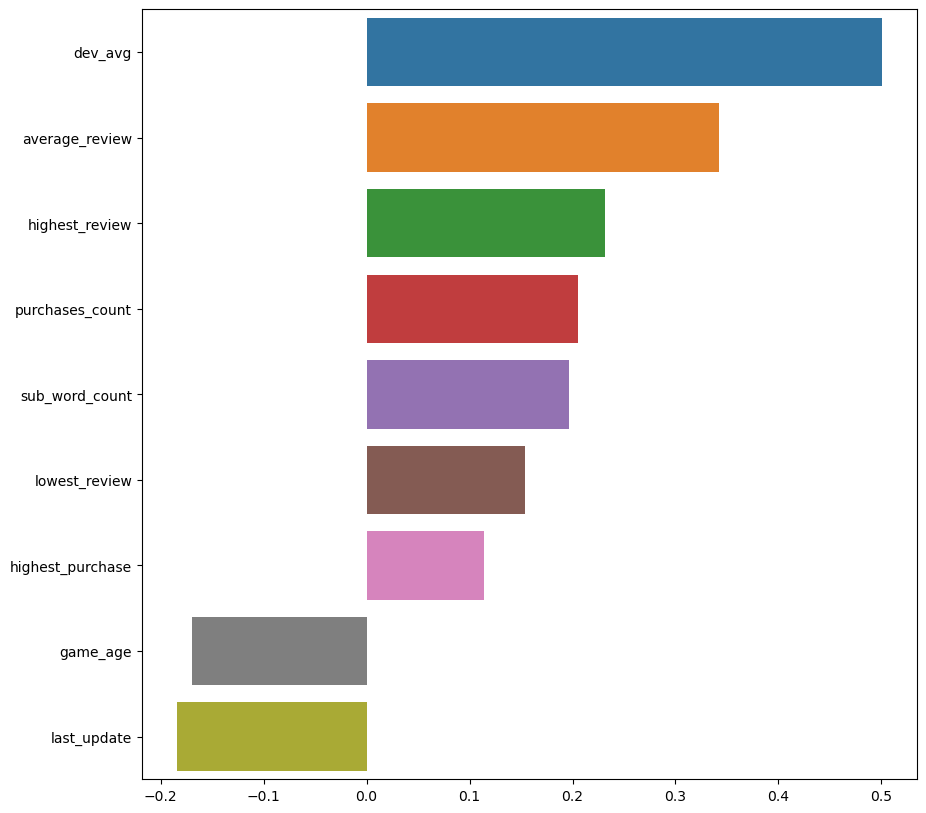

In [84]:
# plot correlation matrix between features and target

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)

corr = corr[abs(corr) > 0.1]

plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.show()

In [85]:
# Scale the features
df_x_scaled = scale_data_minmax(df_x)
df_test_x_scaled = scale_data_minmax(df_test_x, test=True)

# Select the features
df_x_select = select_features(df_x_scaled, df_y)
df_test_x_select = select_features(df_test_x_scaled, df_test_y, test=True)

In [86]:
selector = pickle.load(open('encoders/selector.pkl', 'rb'))
# Print the selected features
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

game_age
last_update
purchases_count
highest_purchase
sub_word_count
sub_sia
dev_avg
lowest_review
highest_review
average_review


In [87]:
from lazypredict.Supervised import LazyClassifier

reg = LazyClassifier(ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(df_x_select, df_test_x_select, df_y, df_test_y)

models = models.sort_values('Accuracy', ascending=False)
models


100%|██████████| 29/29 [00:06<00:00,  4.75it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.68,0.52,None,0.67,0.83
SVC,0.68,0.48,None,0.66,0.42
RidgeClassifierCV,0.67,0.46,None,0.65,0.02
RidgeClassifier,0.67,0.46,None,0.65,0.02
AdaBoostClassifier,0.67,0.47,None,0.65,0.30
ExtraTreesClassifier,0.67,0.50,None,0.66,0.59
LinearSVC,0.67,0.46,None,0.65,0.32
LinearDiscriminantAnalysis,0.66,0.49,None,0.66,0.02
XGBClassifier,0.66,0.50,None,0.65,0.72


In [94]:
# Train SVC model

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svc = SVC(kernel='rbf', C=1.0, gamma='auto', random_state=42)
svc.fit(df_x_select, df_y)

# Print the training accuracy score
svc_train_score = svc.score(df_x_select, df_y)
print('SVC Train Accuracy Score: {0}'.format(svc_train_score))

# Save the model
pickle.dump(svc, open('models/svc.pkl', 'wb'))

# Make predictions
svc_pred = svc.predict(df_test_x_select)

# Calculate the accuracy score
svc_score = accuracy_score(df_test_y, svc_pred)
print('SVC Accuracy Score: {0}'.format(svc_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, svc_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, svc_pred))

plot_scores(svc_train_score, svc_score)

SVC Train Accuracy Score: 0.7120728929384966
SVC Accuracy Score: 0.6721311475409836
Confusion Matrix
[[  0  20   7]
 [  0 132  98]
 [  0  55 237]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      0.57      0.60       230
           2       0.69      0.81      0.75       292

    accuracy                           0.67       549
   macro avg       0.44      0.46      0.45       549
weighted avg       0.64      0.67      0.65       549



In [95]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf = RandomForestClassifier(max_depth=3, random_state=42)
rf.fit(df_x_select, df_y)

# Print the training accuracy score
rf_train_score = rf.score(df_x_select, df_y)
print('Random Forest Train Accuracy Score: {0}'.format(rf_train_score))

# Save the model
pickle.dump(rf, open('models/rf.pkl', 'wb'))

# Make predictions
rf_pred = rf.predict(df_test_x_select)

# Calculate the accuracy score
rf_score = accuracy_score(df_test_y, rf_pred)
print('Random Forest Accuracy Score: {0}'.format(rf_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, rf_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, rf_pred))


Random Forest Train Accuracy Score: 0.730751708428246
Random Forest Accuracy Score: 0.668488160291439
Confusion Matrix
[[  0  21   6]
 [  0 137  93]
 [  0  62 230]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.62      0.60      0.61       230
           2       0.70      0.79      0.74       292

    accuracy                           0.67       549
   macro avg       0.44      0.46      0.45       549
weighted avg       0.63      0.67      0.65       549



In [96]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb = XGBClassifier(max_depth=3, random_state=42, n_estimators=200, learning_rate=0.01, colsample_bytree=0.3, subsample=0.7, reg_alpha=0.1, reg_lambda=10.0)
xgb.fit(df_x_select, df_y)

# Print the training accuracy score
xgb_train_score = xgb.score(df_x_select, df_y)
print('XGBoost Train Accuracy Score: {0}'.format(xgb_train_score))

# Save the model
pickle.dump(xgb, open('models/xgb.pkl', 'wb'))

# Make predictions
xgb_pred = xgb.predict(df_test_x_select)

# Calculate the accuracy score
xgb_score = accuracy_score(df_test_y, xgb_pred)
print('XGBoost Accuracy Score: {0}'.format(xgb_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, xgb_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, xgb_pred))

XGBoost Train Accuracy Score: 0.7316628701594533
XGBoost Accuracy Score: 0.6703096539162113
Confusion Matrix
[[  0  20   7]
 [  0 131  99]
 [  0  55 237]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      0.57      0.60       230
           2       0.69      0.81      0.75       292

    accuracy                           0.67       549
   macro avg       0.44      0.46      0.45       549
weighted avg       0.63      0.67      0.65       549



In [126]:
from catboost import CatBoostClassifier

# Train CatBoost model
cat = CatBoostClassifier(verbose=1000, max_depth=4, random_state=42, boosting_type='Ordered', border_count=32, iterations=1100, l2_leaf_reg=36, learning_rate=0.02, random_strength=0.3)
cat.fit(df_x_select, df_y)

# Print the training accuracy score
cat_train_score = cat.score(df_x_select, df_y)
print('CatBoost Train Accuracy Score: {0}'.format(cat_train_score))

# Save the model
pickle.dump(cat, open('models/cat.pkl', 'wb'))

# Make predictions
cat_pred = cat.predict(df_test_x_select)

# Calculate the accuracy score
cat_score = accuracy_score(df_test_y, cat_pred)
print('CatBoost Accuracy Score: {0}'.format(cat_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, cat_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, cat_pred))

0:	learn: 1.0869255	total: 3.94ms	remaining: 4.33s
1000:	learn: 0.5545785	total: 3.11s	remaining: 308ms
1099:	learn: 0.5500830	total: 3.43s	remaining: 0us
CatBoost Train Accuracy Score: 0.7430523917995444
CatBoost Accuracy Score: 0.697632058287796
Confusion Matrix
[[  2  18   7]
 [  0 153  77]
 [  0  64 228]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.07      0.14        27
           1       0.65      0.67      0.66       230
           2       0.73      0.78      0.75       292

    accuracy                           0.70       549
   macro avg       0.79      0.51      0.52       549
weighted avg       0.71      0.70      0.68       549



In [76]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'depth': [2],
    'l2_leaf_reg': [36],
    'border_count': [32],
    'boosting_type': ['Ordered'],
    'random_strength': [0.3, 0.5],
    'learning_rate': [0.02, 0.03],
    'iterations': [2000, 3000],
}

# Create a CatBoost regressor
clf = CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', random_seed=42, verbose=250)

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=2)
grid_search.fit(df_x_select, df_y, eval_set=(df_test_x_select, df_test_y))

# Print best hyperparameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train final model with best hyperparameters on entire dataset
best_clf = CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', random_seed=42, verbose=250, **grid_search.best_params_)
best_clf.fit(df_x_select, df_y)

# Print the training accuracy score
cat_train_score = best_clf.score(df_x_select, df_y)
print('CatBoost Train Accuracy Score: {0}'.format(cat_train_score))

# Save the model
pickle.dump(best_clf, open('models/cat_hyper.pkl', 'wb'))

# Make predictions
cat_pred = best_clf.predict(df_test_x_select)

# Calculate the accuracy score
cat_score = accuracy_score(df_test_y, cat_pred)
print('CatBoost Accuracy Score: {0}'.format(cat_score))

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, cat_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, cat_pred))

# Display the scores
plot_scores(cat_train_score, cat_score)


"""
Shrink model to first 1765 iterations.
Best parameters: {'boosting_type': 'Ordered', 'border_count': 32, 'depth': 2, 'iterations': 2000, 'l2_leaf_reg': 36, 'learning_rate': 0.02, 'random_strength': 0.3}
Best score: 0.7189066059225512
0:	learn: 0.6514806	total: 3.36ms	remaining: 6.72s
250:	learn: 0.7184510	total: 664ms	remaining: 4.63s
500:	learn: 0.7257403	total: 1.32s	remaining: 3.94s
750:	learn: 0.7271071	total: 1.97s	remaining: 3.28s
1000:	learn: 0.7302961	total: 2.64s	remaining: 2.63s
1250:	learn: 0.7316629	total: 3.31s	remaining: 1.98s
1500:	learn: 0.7321185	total: 3.96s	remaining: 1.32s
1750:	learn: 0.7330296	total: 4.61s	remaining: 656ms
1999:	learn: 0.7348519	total: 5.25s	remaining: 0us
CatBoost Train Accuracy Score: 0.7348519362186788
CatBoost Accuracy Score: 0.6885245901639344
    
"""

0:	learn: 0.6514806	test: 0.5883424	best: 0.5883424 (0)	total: 2.9ms	remaining: 5.8s
250:	learn: 0.7184510	test: 0.6739526	best: 0.6775956 (161)	total: 665ms	remaining: 4.63s
500:	learn: 0.7257403	test: 0.6739526	best: 0.6775956 (161)	total: 1.32s	remaining: 3.96s
750:	learn: 0.7271071	test: 0.6775956	best: 0.6794171 (654)	total: 2.02s	remaining: 3.36s
1000:	learn: 0.7302961	test: 0.6739526	best: 0.6794171 (654)	total: 2.7s	remaining: 2.69s
1250:	learn: 0.7316629	test: 0.6757741	best: 0.6794171 (654)	total: 3.37s	remaining: 2.02s
1500:	learn: 0.7321185	test: 0.6812386	best: 0.6812386 (1492)	total: 4.06s	remaining: 1.35s
1750:	learn: 0.7330296	test: 0.6867031	best: 0.6867031 (1734)	total: 4.72s	remaining: 672ms
1999:	learn: 0.7348519	test: 0.6885246	best: 0.6903461 (1764)	total: 5.39s	remaining: 0us

bestTest = 0.6903460838
bestIteration = 1764

Shrink model to first 1765 iterations.
Best parameters: {'boosting_type': 'Ordered', 'border_count': 32, 'depth': 2, 'iterations': 2000, 'l2_le

"\nShrink model to first 1765 iterations.\nBest parameters: {'boosting_type': 'Ordered', 'border_count': 32, 'depth': 2, 'iterations': 2000, 'l2_leaf_reg': 36, 'learning_rate': 0.02, 'random_strength': 0.3}\nBest score: 0.7189066059225512\n0:\tlearn: 0.6514806\ttotal: 3.36ms\tremaining: 6.72s\n250:\tlearn: 0.7184510\ttotal: 664ms\tremaining: 4.63s\n500:\tlearn: 0.7257403\ttotal: 1.32s\tremaining: 3.94s\n750:\tlearn: 0.7271071\ttotal: 1.97s\tremaining: 3.28s\n1000:\tlearn: 0.7302961\ttotal: 2.64s\tremaining: 2.63s\n1250:\tlearn: 0.7316629\ttotal: 3.31s\tremaining: 1.98s\n1500:\tlearn: 0.7321185\ttotal: 3.96s\tremaining: 1.32s\n1750:\tlearn: 0.7330296\ttotal: 4.61s\tremaining: 656ms\n1999:\tlearn: 0.7348519\ttotal: 5.25s\tremaining: 0us\nCatBoost Train Accuracy Score: 0.7348519362186788\nCatBoost Accuracy Score: 0.6885245901639344\n    \n"

In [123]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf = RandomForestClassifier(max_depth=5, random_state=42, n_estimators=400, min_samples_leaf=2, min_samples_split=5, max_features='auto', bootstrap=True)
rf.fit(df_x_select, df_y)

# Print the training accuracy score
rf_train_score = rf.score(df_x_select, df_y)
print('Random Forest Train Accuracy Score: {0}'.format(rf_train_score))

# Save the model
pickle.dump(rf, open('models/rf.pkl', 'wb'))

# Make predictions
rf_pred = rf.predict(df_test_x_select)

# Calculate the accuracy score
rf_score = accuracy_score(df_test_y, rf_pred)

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, rf_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, rf_pred))

# Display the scores
plot_scores(rf_train_score, rf_score)

Random Forest Train Accuracy Score: 0.7485193621867882
Confusion Matrix
[[  0  20   7]
 [  0 149  81]
 [  0  64 228]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      0.65      0.64       230
           2       0.72      0.78      0.75       292

    accuracy                           0.69       549
   macro avg       0.45      0.48      0.46       549
weighted avg       0.65      0.69      0.67       549



In [120]:
# Random Forest Classifier with hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Create a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=2)
grid_search.fit(df_x_select, df_y)

# Print best hyperparameters and corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Train final model with best hyperparameters on entire dataset
best_clf = RandomForestClassifier(random_state=42, **grid_search.best_params_)
best_clf.fit(df_x_select, df_y)

# Print the training accuracy score
rf_train_score = best_clf.score(df_x_select, df_y)
print('Random Forest Train Accuracy Score: {0}'.format(rf_train_score))

# Save the model 
pickle.dump(best_clf, open('models/rf_hyper.pkl', 'wb'))

# Make predictions
rf_pred = best_clf.predict(df_test_x_select)

# Calculate the accuracy score
rf_score = accuracy_score(df_test_y, rf_pred)

# Print the confusion matrix
print('Confusion Matrix')
print(confusion_matrix(df_test_y, rf_pred))

# Print the classification report
print('Classification Report')
print(classification_report(df_test_y, rf_pred))

# Display the scores
plot_scores(rf_train_score, rf_score)

Best parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Best score: 0.7148063781321183
Random Forest Train Accuracy Score: 0.7521640091116173
Confusion Matrix
[[  0  20   7]
 [  0 145  85]
 [  0  63 229]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      0.63      0.63       230
           2       0.71      0.78      0.75       292

    accuracy                           0.68       549
   macro avg       0.45      0.47      0.46       549
weighted avg       0.65      0.68      0.66       549



"\nBest parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}\nBest score: 0.7120728929384966\nRandom Forest Train Accuracy Score: 0.7498861047835991\n"